**PART 5: Proximal Gradient and LASSO**

Importing libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import norm 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.linalg import svdvals
from scipy.optimize import fmin_l_bfgs_b
from math import sqrt
from matplotlib.pyplot import figure


Loading and cleaning the dataset

In [4]:
data=pd.read_csv('energy.csv')
data_copy=data.copy()
A = data_copy[['Relative_Compactness', 'Surface_Area', 'Wall_Area','Roof_Area','Overall_Height', 'Orientation', 'Glazing_Area','Glazing_Area_Distribution']]
y=data_copy[['Heating_Load']]

In [5]:
m=A.mean(axis=0)
s=A.std(axis=0)
my=y.mean()

A=(A-m)/s
y=y-my

n=A.shape[0]
d=A.shape[1]

A_mat=A.to_numpy()
y_mat=y.to_numpy().reshape(n)

Usefuls functions and classes (as seen during the practical sessions):

In [6]:
# Python class for regression problems
class RegressionPb(object):

    # Instantiate the class
    def __init__(self, A, y,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        
    
    # Objective value
    def fun(self, x):
        if self.loss=='l2':
            return norm(self.A.dot(x) - self.y) ** 2 / (2. * self.n) 
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            return np.mean(np.log(1. + np.exp(-yAx))) 
    
    # Full gradient computation
    def grad(self, x):
        if self.loss=='l2':
            return self.A.T.dot(self.A.dot(x) - self.y) / self.n
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            aux = 1. / (1. + np.exp(yAx))
            return - (self.A.T).dot(self.y * aux) / self.n 

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n 
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) 
        return L
    
    # ''Strong'' convexity constant (could be zero)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n 
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

In [7]:
# Implementation of gradient descent
def gd_l2(x0,problem,lbda,xtarget,stepchoice=0,step0=1, n_iter=1000, verbose=False): 

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # gradient norms
    normgrads = []
    
    # Lipschitz constant for the regularized problem
    L = problem.lipgrad() + lbda
    
    # Initial value of current iterate   
    x = x0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective
    obj = problem.fun(x)  + lbda* norm(x) ** 2 / 2.
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    # Current gradient norm
    g = problem.grad(x) + lbda * x
    ng = norm(g)
    normgrads.append(ng)

    # Plot the initial values if required
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "dist","ngrad"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8),("%.2e" % ng).rjust(8)]))
    
    ####################
    # Main loop
    while (k < n_iter):

        # Select the stepsize and perform the update
        if stepchoice==0:
            x[:] = x - (1/L) * g
        elif stepchoice==1:
            x[:] = x - (step0/(k+1))*g
        else:
            x[:] = x - (step0/(sqrt(k+1)))*g
        
        # Compute and plot the new objective value and distance to the minimum
        obj = problem.fun(x) + lbda * norm(x)**2 /2.
        objvals.append(obj)
        nmin = norm(x-xtarget)
        normits.append(nmin)
        # Compute the gradient
        g = problem.grad(x) + lbda * x
        ng = norm(g)
        normgrads.append(ng)
        
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8),("%.2e" % ng).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
    
    # End main loop
    ######################
    
    # Output
    x_output = x.copy()
    return x_output, np.array(objvals), np.array(normits), np.array(normgrads)

In [8]:
# Implementation of ISTA (Iterative Shrinkage-Thresholding Algorithm): for l1-regularization
def ista(x0,problem,lbda,stepchoice=0,step0=1, n_iter=1000,verbose=False): 
    """
        A code for ISTA with various step choices.
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun(x) evaluates the objective function (which is assumed to be a finite sum of functions) at a given vector w
                problem.n returns the number of components in the finite sum
                problem.grad(x) evaluates the gradient of the smooth part of the objective function at a vector w
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
            lbda: Regularization parameter
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/(k+1)
                2: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations
            
        Outputs:
            x_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length n_iter at most)
    """   
    
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Initial value of current iterate   
    x = x0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj);

    step=step0 # Initialize constant stepsize
    threshold=0 # Initialize threshold for proximal step
    
    # Display initial quantities
    if verbose:
        print("ISTA:")
        print(' | '.join([name.center(8) for name in ["iter", "fval"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))
    
    
    ##########################
    # Main loop
    while (k < n_iter):
        # Compute the gradient of the smooth part
        g = problem.grad(x)
        # Select the stepsize
        if stepchoice==0:
            step = 1/L
        elif (stepchoice==1):
            step = step0/(k+1)
        else:
            step = step0/(sqrt(k+1))
        
        # Compute the proximal gradient step
        for i in range(problem.d):
            vali = x[i]-step*g[i]
            threshold = step*lbda
            if vali < -threshold:
                x[i] = vali+threshold
            elif vali > threshold:
                x[i] = vali-threshold
            else:
                x[i] = 0
            
        # Update objective value and iteration index
        obj = problem.fun(x)
        objvals.append(obj);
        k += 1
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))       
        
    # Output 
    x_output = x.copy()
          
    return x_output, np.array(objvals)

In [10]:
class RegPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            A: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of A
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
            lbda: Regularization parameter
    '''
   
    # Instantiate the class
    def __init__(self, A, y,lbda=0,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        self.lbda = lbda
        
    
    # Objective value
    def fun(self, x):
        if self.loss=='l2':
            return norm(self.A.dot(x) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            return np.mean(np.log(1. + np.exp(-yAx))) + self.lbda * norm(x) ** 2 / 2.
    
    # Partial objective value
    def f_i(self, i, x):
        if self.loss=='l2':
            return norm(self.A[i].dot(x) - self.y[i]) ** 2 / (2.) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAxi = self.y[i] * np.dot(self.A[i], x)
            return np.log(1. + np.exp(- yAxi)) + self.lbda * norm(x) ** 2 / 2.
    
    # Full gradient computation
    def grad(self, x):
        if self.loss=='l2':
            return self.A.T.dot(self.A.dot(x) - self.y) / self.n + self.lbda * x
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            aux = 1. / (1. + np.exp(yAx))
            return - (self.A.T).dot(self.y * aux) / self.n + self.lbda * x
    
    # Partial gradient
    def grad_i(self,i,x):
        a_i = self.A[i]
        if self.loss=='l2':
            return (a_i.dot(x) - self.y[i]) * a_i + self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* a_i.dot(x)))
            grad += self.lbda * x
            return grad

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n # More efficient than computing ||A^T A||
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda
# Stochastic gradient implementation
def stoch_grad(x0,problem,xtarget,stepchoice=0,step0=1, n_iter=50,nb=1,with_replace=False,verbose=False): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            x0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            xtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                t>0: Step size decreasing in 1/(k+1)**t
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
                1: Classical stochastic gradient algorithm (default value)
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)
            
        Outputs:
            x_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    x = x0.copy()
    nx = norm(x)

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    
    if verbose:
        # Plot initial quantities of interest
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],x)
            sg = sg + gi
        sg = (1/nb)*sg
            
        if stepchoice==0:
            x[:] = x - (step0/L) * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            x[:] = x - sk * sg
        
        nx = norm(x) #Computing the norm to measure divergence 

        obj = problem.fun(x)
        nmin = norm(x-xtarget)
        
       
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    x_output = x.copy()
    
    return x_output, np.array(objvals), np.array(normits)



**Question 1**

Adding l2 regularization term to the objective function in SGD.
Experimenting with different values of lambda.



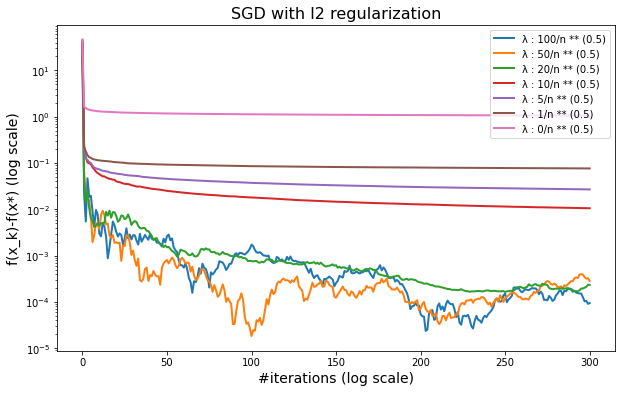

In [16]:
nb_epochs = 300
x0 = np.zeros(d)
valslbda = [100, 50, 20, 10,5,1,0]
N2 = len(valslbda)

plt.figure(figsize=(10, 6))
plt.set_cmap("RdPu")
plt.title("SGD with l2 regularization", fontsize=16)
x_init = np.zeros(d)
for val in range(N2):
    objs = np.zeros(n)
    lbda = valslbda[val] / n ** (0.5)
    pblinreg = RegPb(A_mat, y_mat,lbda,loss='l2')
    # Use L-BFGS-B to determine a solution for both problems
    # Compute the optimal solution for linear regression
    x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
    _, objs, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.6, n_iter=int(nb_epochs*n),nb=1,verbose=False)
    plt.semilogy(objs-f_min_lin, label="λ : "+str(valslbda[val])+"/n ** (0.5)", lw=2)
plt.xlabel("#iterations (log scale)", fontsize=14)
plt.ylabel("f(x_k)-f(x*) (log scale)", fontsize=14)
plt.legend(loc=1);



**Question 2**

Adding l2 regularization term to the objective function in Gradient Descent.
Experimenting with different values of lambda.



In [17]:
#instantiating a regression problem, no ridge penalty
x_init = np.zeros(d)
lbda = 0
pblinreg = RegressionPb(A_mat, y_mat,loss='l2')

#Using L-BFGS-B algorithm to determine a solution

x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)

# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))

4.260264443454085
2.5196998677254253e-10


Nonzero coefficients with lbda=0: 8
Nonzero coefficients with lbda=0.001: 8
Nonzero coefficients with lbda=0.005: 8
Nonzero coefficients with lbda=0.05: 7
Nonzero coefficients with lbda=0.5: 7
Nonzero coefficients with lbda=1: 5
Nonzero coefficients with lbda=2: 5
Nonzero coefficients with lbda=4: 2


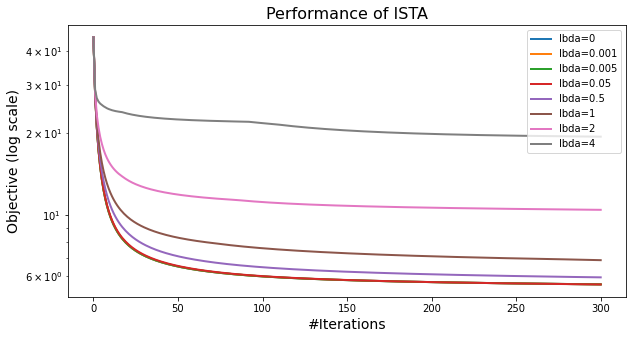

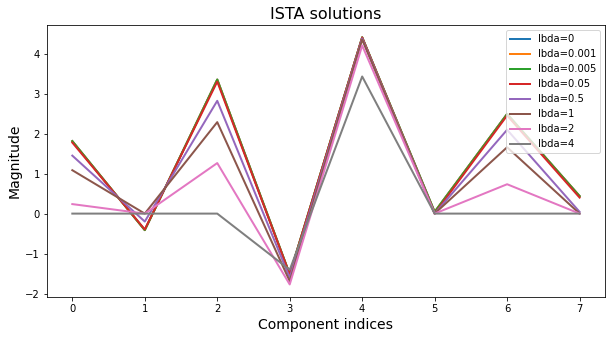

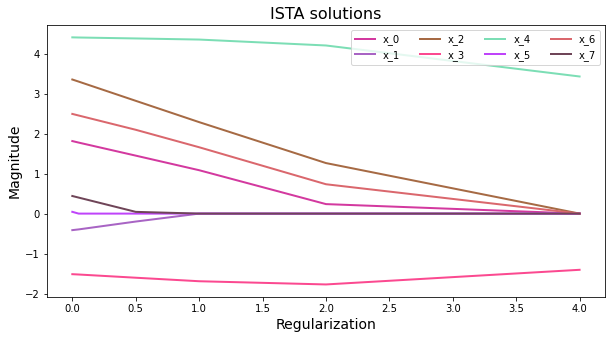

In [ ]:
# Testing l1 regularization 
lvals = [0, 0.001, 0.005, 0.05, 0.5, 1, 2, 4]
nlbda = len(lvals)
lbda = 100
x0 = np.ones(d)
Xsol = np.zeros((d,nlbda))

plt.figure(figsize=(10, 5))
for i in range(nlbda):
    lbda =lvals[i]
    Xsol[:,i], obj_is = ista(x0,pblinreg,lbda,stepchoice=2,step0=0.08, n_iter=300)
    print("Nonzero coefficients with lbda="+str(lbda)+": "+str(np.count_nonzero(Xsol[:,i])))
    plt.semilogy(obj_is, label="lbda="+str(lbda), lw=2)
plt.title("Performance of ISTA", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc=1)

plt.figure(figsize=(10, 5))
for i in range(nlbda):
    plt.plot(Xsol[:,i],label="lbda="+str(lvals[i]), lw=2)
plt.title("ISTA solutions", fontsize=16)
plt.xlabel("Component indices", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(loc=1)

plt.figure(figsize=(10, 5))
for i in range(d):
    plt.plot(lvals,Xsol[i,:],label="x_"+str(i),c=np.random.rand(3,), lw=2)
plt.title("ISTA solutions", fontsize=16)
plt.xlabel("Regularization", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(ncol=4,loc=1)

